# Time-Series EV Sales Forecasting

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

## Step 1: Load Data

In [24]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mafzal19/electric-vehicle-sales-by-state-in-india")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\gryff\.cache\kagglehub\datasets\mafzal19\electric-vehicle-sales-by-state-in-india\versions\1


In [42]:
ev_sales = pd.read_csv(str(path) + "/EV_Dataset.csv")
ev_sales.head()

,Year,Month_Name,Date,State,Vehicle_Class,Vehicle_Category,Vehicle_Type,EV_Sales_Quantity
0,2014.0,jan,1/1/2014,Andhra Pradesh,ADAPTED VEHICLE,Others,Others,0.0
1,2014.0,jan,1/1/2014,Andhra Pradesh,AGRICULTURAL TRACTOR,Others,Others,0.0
2,2014.0,jan,1/1/2014,Andhra Pradesh,AMBULANCE,Others,Others,0.0
3,2014.0,jan,1/1/2014,Andhra Pradesh,ARTICULATED VEHICLE,Others,Others,0.0
4,2014.0,jan,1/1/2014,Andhra Pradesh,BUS,Bus,Bus,0.0


In [43]:
# Convert to datetime
ev_sales['Date'] = pd.to_datetime(ev_sales['Date'])

# Clean state names
ev_sales['State'] = ev_sales['State'].str.strip().str.title()

print(f"Date range: {ev_sales['Date'].min()} to {ev_sales['Date'].max()}")
print(f"States: {ev_sales['State'].nunique()}")
print(f"Total records: {len(ev_sales):,}")

Date range: 2014-01-01 00:00:00 to 2024-01-01 00:00:00
States: 34
Total records: 96,845


In [44]:
# Aggregate to State-Month level
state_monthly = ev_sales.groupby(['State', 'Date'])['EV_Sales_Quantity'].sum().reset_index()
state_monthly = state_monthly.sort_values(['State', 'Date'])

# Add time components
state_monthly['Year'] = state_monthly['Date'].dt.year
state_monthly['Month'] = state_monthly['Date'].dt.month
state_monthly['Quarter'] = state_monthly['Date'].dt.quarter

print(f"\nState-Month combinations: {len(state_monthly):,}")
print(f"Average months per state: {len(state_monthly) / state_monthly['State'].nunique():.1f}")


State-Month combinations: 4,112
Average months per state: 120.9


## Step 2: Feature Engineering with Proper Cleaning

In [45]:
# LAG FEATURES

print("Creating lag features...")

for lag in [1, 3, 6, 12]:
    state_monthly[f'sales_lag_{lag}m'] = (
        state_monthly.groupby('State')['EV_Sales_Quantity'].shift(lag)
    )

print("✓ Lag features created")

Creating lag features...
✓ Lag features created


In [46]:
# ROLLING STATISTICS

print("Creating rolling statistics...")

for window in [3, 6, 12]:
    state_monthly[f'sales_ma_{window}m'] = (
        state_monthly.groupby('State')['EV_Sales_Quantity']
        .rolling(window=window, min_periods=1)
        .mean()
        .reset_index(0, drop=True)
    )

state_monthly['sales_std_6m'] = (
    state_monthly.groupby('State')['EV_Sales_Quantity']
    .rolling(window=6, min_periods=1)
    .std()
    .reset_index(0, drop=True)
)

print("✓ Rolling statistics created")

Creating rolling statistics...
✓ Rolling statistics created


In [47]:
# GROWTH RATES 

print("Creating growth rate features...")

# Helper function for safe percentage change
def safe_pct_change(series, periods=1):
    """Calculate percentage change, handling zeros and preventing inf"""
    result = series.pct_change(periods=periods)
    # Cap extreme values at +/-500%
    result = result.clip(-5, 5)
    return result

# Month-over-month growth
state_monthly['growth_mom'] = (
    state_monthly.groupby('State')['EV_Sales_Quantity']
    .transform(lambda x: safe_pct_change(x, periods=1))
)

# Year-over-year growth
state_monthly['growth_yoy'] = (
    state_monthly.groupby('State')['EV_Sales_Quantity']
    .transform(lambda x: safe_pct_change(x, periods=12))
)

# 6-month growth
state_monthly['growth_6m'] = (
    state_monthly.groupby('State')['EV_Sales_Quantity']
    .transform(lambda x: safe_pct_change(x, periods=6))
)

# Growth acceleration
state_monthly['growth_acceleration'] = (
    state_monthly.groupby('State')['growth_mom'].diff()
)

print("✓ Growth rate features created")

Creating growth rate features...
✓ Growth rate features created


In [48]:
# TREND INDICATORS

print("Creating trend indicators...")

state_monthly['months_in_market'] = state_monthly.groupby('State').cumcount() + 1

state_monthly['cumulative_sales'] = (
    state_monthly.groupby('State')['EV_Sales_Quantity'].cumsum()
)

# Market stage as numeric (not categorical to avoid issues)
state_monthly['market_stage_numeric'] = pd.cut(
    state_monthly['cumulative_sales'],
    bins=[0, 1000, 10000, 50000, float('inf')],
    labels=[1, 2, 3, 4]
).astype(float)

print("✓ Trend indicators created")

Creating trend indicators...
✓ Trend indicators created


In [49]:
# SEASONALITY

print("Creating seasonality features...")

# One-hot encode months
month_dummies = pd.get_dummies(state_monthly['Month'], prefix='month', drop_first=True)
state_monthly = pd.concat([state_monthly, month_dummies], axis=1)

# One-hot encode quarters
quarter_dummies = pd.get_dummies(state_monthly['Quarter'], prefix='quarter', drop_first=True)
state_monthly = pd.concat([state_monthly, quarter_dummies], axis=1)

print("✓ Seasonality features created")
print(f"Total features: {len(state_monthly.columns)}")

Creating seasonality features...
✓ Seasonality features created
Total features: 35


In [50]:
# CLEAN ALL INF AND NAN VALUES
print("DATA CLEANING")

print(f"\nBefore cleaning:")
print(f"  Total rows: {len(state_monthly)}")
print(f"  NaN values: {state_monthly.isna().sum().sum()}")
print(f"  Inf values: {np.isinf(state_monthly.select_dtypes(include=[np.number])).sum().sum()}")

# Replace inf with NaN first
state_monthly = state_monthly.replace([np.inf, -np.inf], np.nan)

# Check which columns have NaN
nan_cols = state_monthly.columns[state_monthly.isna().any()].tolist()
print(f"\nColumns with NaN: {len(nan_cols)}")
if nan_cols:
    print(f"  {nan_cols[:10]}...")  # Show first 10

# Fill NaN with 0 for growth rates (represents no change)
growth_cols = [col for col in state_monthly.columns if 'growth' in col]
state_monthly[growth_cols] = state_monthly[growth_cols].fillna(0)

# Fill NaN with forward fill for other features (use previous value)
numeric_cols = state_monthly.select_dtypes(include=[np.number]).columns
state_monthly[numeric_cols] = state_monthly.groupby('State')[numeric_cols].transform(lambda x: x.ffill())

# Fill any remaining NaN with 0
state_monthly = state_monthly.fillna(0)

print(f"\nAfter cleaning:")
print(f"  NaN values: {state_monthly.isna().sum().sum()}")
print(f"  Inf values: {np.isinf(state_monthly.select_dtypes(include=[np.number])).sum().sum()}")
print(f"  State column exists: {'State' in state_monthly.columns}")
print("\n✓ Data cleaned successfully!")

DATA CLEANING

Before cleaning:
  Total rows: 4112
  NaN values: 5616
  Inf values: 0

Columns with NaN: 10
  ['sales_lag_1m', 'sales_lag_3m', 'sales_lag_6m', 'sales_lag_12m', 'sales_std_6m', 'growth_mom', 'growth_yoy', 'growth_6m', 'growth_acceleration', 'market_stage_numeric']...

After cleaning:
  NaN values: 0
  Inf values: 0
  State column exists: True

✓ Data cleaned successfully!


## Step 3: Train/Test Split

In [51]:
# Use last 12 months for testing
test_months = 12

max_date = state_monthly['Date'].max()
cutoff_date = max_date - pd.DateOffset(months=test_months)

print("TIME-SERIES DATA SPLIT")

print(f"\nTraining: {state_monthly['Date'].min().date()} to {cutoff_date.date()}")
print(f"Testing:  {cutoff_date.date()} to {max_date.date()}")

train = state_monthly[state_monthly['Date'] <= cutoff_date].copy()
test = state_monthly[state_monthly['Date'] > cutoff_date].copy()

print(f"\nTraining samples: {len(train):,}")
print(f"Testing samples:  {len(test):,}")

TIME-SERIES DATA SPLIT

Training: 2014-01-01 to 2023-01-01
Testing:  2023-01-01 to 2024-01-01

Training samples: 3,704
Testing samples:  408


## Step 4: Prepare Features and Train Model

In [52]:
# Select features
exclude_cols = ['State', 'EV_Sales_Quantity', 'Date', 'Year', 'Month', 'Quarter']
feature_cols = [col for col in state_monthly.columns if col not in exclude_cols]

print(f"Features selected: {len(feature_cols)}")

# Prepare train and test sets
X_train = train[feature_cols]
y_train = train['EV_Sales_Quantity']
X_test = test[feature_cols]
y_test = test['EV_Sales_Quantity']

# Final check for inf/nan in X and y
print(f"\nFinal data check:")
print(f"  X_train - NaN: {X_train.isna().sum().sum()}, Inf: {np.isinf(X_train).sum().sum()}")
print(f"  y_train - NaN: {y_train.isna().sum()}, Inf: {np.isinf(y_train).sum()}")
print(f"  X_test - NaN: {X_test.isna().sum().sum()}, Inf: {np.isinf(X_test).sum().sum()}")
print(f"  y_test - NaN: {y_test.isna().sum()}, Inf: {np.isinf(y_test).sum()}")

print(f"\n✓ Data ready for training!")
print(f"  X_train shape: {X_train.shape}")
print(f"  X_test shape: {X_test.shape}")

Features selected: 29

Final data check:
  X_train - NaN: 0, Inf: 0
  y_train - NaN: 0, Inf: 0
  X_test - NaN: 0, Inf: 0
  y_test - NaN: 0, Inf: 0

✓ Data ready for training!
  X_train shape: (3704, 29)
  X_test shape: (408, 29)


In [60]:
# TRAIN XGBOOST MODEL

print("TRAINING XGBOOST MODEL")

model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method='hist'  # Faster and more robust
)

print("\nTraining in progress...")
model.fit(X_train, y_train)
print("✓ Training complete!")

TRAINING XGBOOST MODEL

Training in progress...
✓ Training complete!


## Step 5: Evaluate Performance

In [61]:
# Generate predictions
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

print("MODEL PERFORMANCE")

# Training metrics
train_mae = mean_absolute_error(y_train, train_preds)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
train_r2 = r2_score(y_train, train_preds)

print(f"\n📊 TRAINING SET:")
print(f"  MAE:  {train_mae:,.2f}")
print(f"  RMSE: {train_rmse:,.2f}")
print(f"  R²:   {train_r2:.4f}")

# Test metrics
test_mae = mean_absolute_error(y_test, test_preds)
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
test_r2 = r2_score(y_test, test_preds)
test_mape = np.mean(np.abs((y_test - test_preds) / (y_test + 1))) * 100

print(f"\n🎯 TEST SET (Future Forecasting):")
print(f"  MAE:   {test_mae:,.2f}")
print(f"  RMSE:  {test_rmse:,.2f}")
print(f"  MAPE:  {test_mape:.2f}%")
print(f"  R²:    {test_r2:.4f}")

mean_sales = y_test.mean()
print(f"\n📈 CONTEXT:")
print(f"  Average sales: {mean_sales:,.2f}")
print(f"  MAE as % of avg: {(test_mae/mean_sales)*100:.2f}%")

print(f"\n💡 INTERPRETATION:")
if test_r2 > 0.7:
    print(f"  ✓ EXCELLENT - Strong predictive power!")
elif test_r2 > 0.5:
    print(f"  ✓ GOOD - Useful for planning")
elif test_r2 > 0.3:
    print(f"  ⚠ MODERATE - Consider improvements")
else:
    print(f"  ⚠ WEAK - Needs refinement")

MODEL PERFORMANCE

📊 TRAINING SET:
  MAE:  10.74
  RMSE: 26.42
  R²:   0.9997

🎯 TEST SET (Future Forecasting):
  MAE:   491.45
  RMSE:  1,679.39
  MAPE:  28.40%
  R²:    0.9035

📈 CONTEXT:
  Average sales: 3,837.06
  MAE as % of avg: 12.81%

💡 INTERPRETATION:
  ✓ EXCELLENT - Strong predictive power!


TOP 15 MOST IMPORTANT FEATURES
         feature  importance
     sales_ma_3m    0.481113
     sales_ma_6m    0.374872
    sales_lag_1m    0.092198
    sales_ma_12m    0.017344
      growth_mom    0.005218
    sales_lag_6m    0.004659
       growth_6m    0.003877
        month_12    0.002607
    sales_std_6m    0.002513
        month_10    0.001750
      growth_yoy    0.001731
   sales_lag_12m    0.001444
months_in_market    0.001437
        month_11    0.001252
         month_3    0.001063


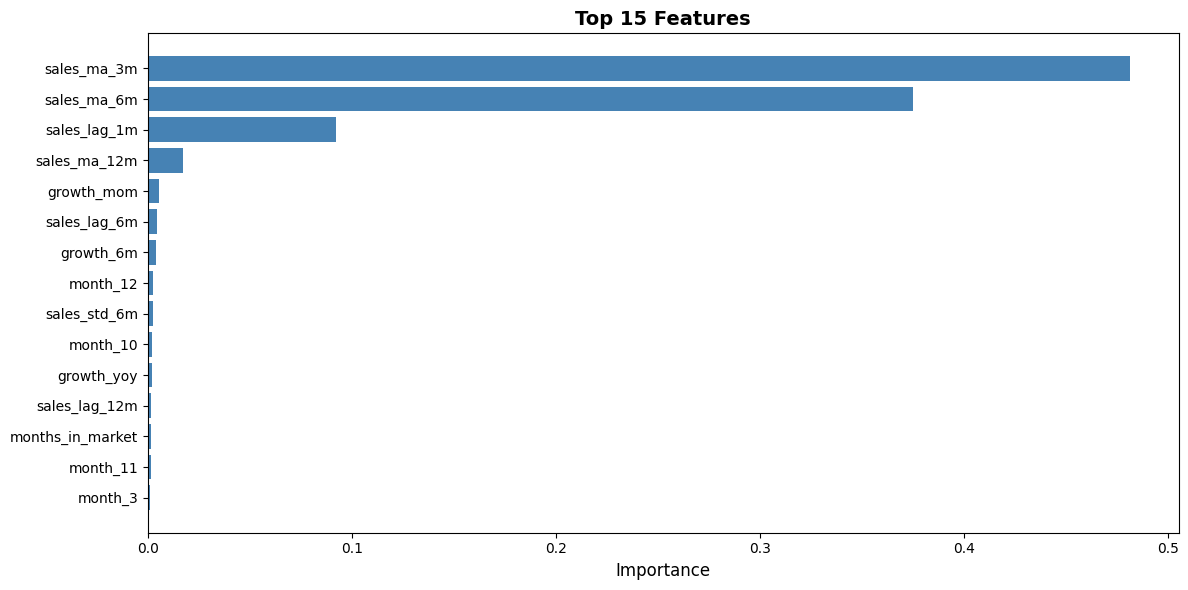

In [62]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("TOP 15 MOST IMPORTANT FEATURES")
print(feature_importance.head(15).to_string(index=False))

# Plot
plt.figure(figsize=(12, 6))
top15 = feature_importance.head(15)
plt.barh(top15['feature'], top15['importance'], color='steelblue')
plt.xlabel('Importance', fontsize=12)
plt.title('Top 15 Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Step 6: Visualizations

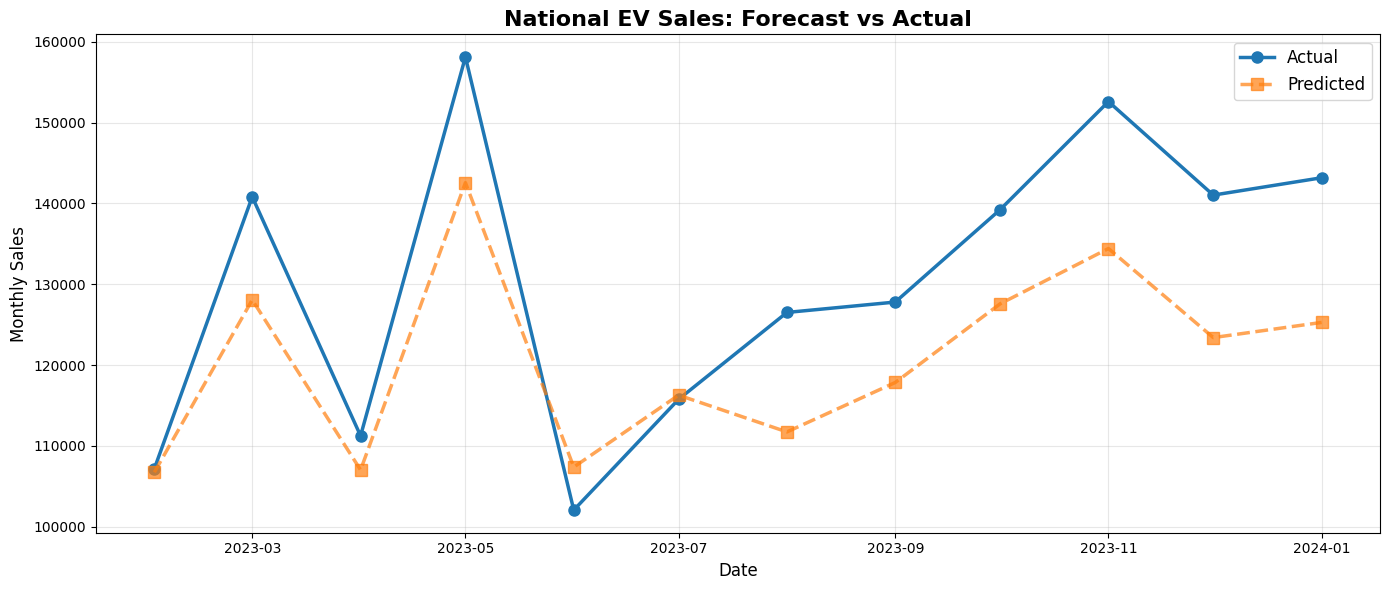

In [63]:
# National forecast
test_national = test.copy()  # Create a separate copy
test_national['predictions'] = test_preds
monthly_actual = test_national.groupby('Date')['EV_Sales_Quantity'].sum()
monthly_pred = test_national.groupby('Date')['predictions'].sum()

plt.figure(figsize=(14, 6))
plt.plot(monthly_actual.index, monthly_actual.values,
         label='Actual', marker='o', linewidth=2.5, markersize=8)
plt.plot(monthly_pred.index, monthly_pred.values,
         label='Predicted', marker='s', linewidth=2.5, markersize=8, alpha=0.7, linestyle='--')

plt.title('National EV Sales: Forecast vs Actual', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Monthly Sales', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [65]:
test_original = state_monthly[state_monthly['Date'] > cutoff_date][['State', 'Date', 'EV_Sales_Quantity']].copy()
test_original['predictions'] = test_preds

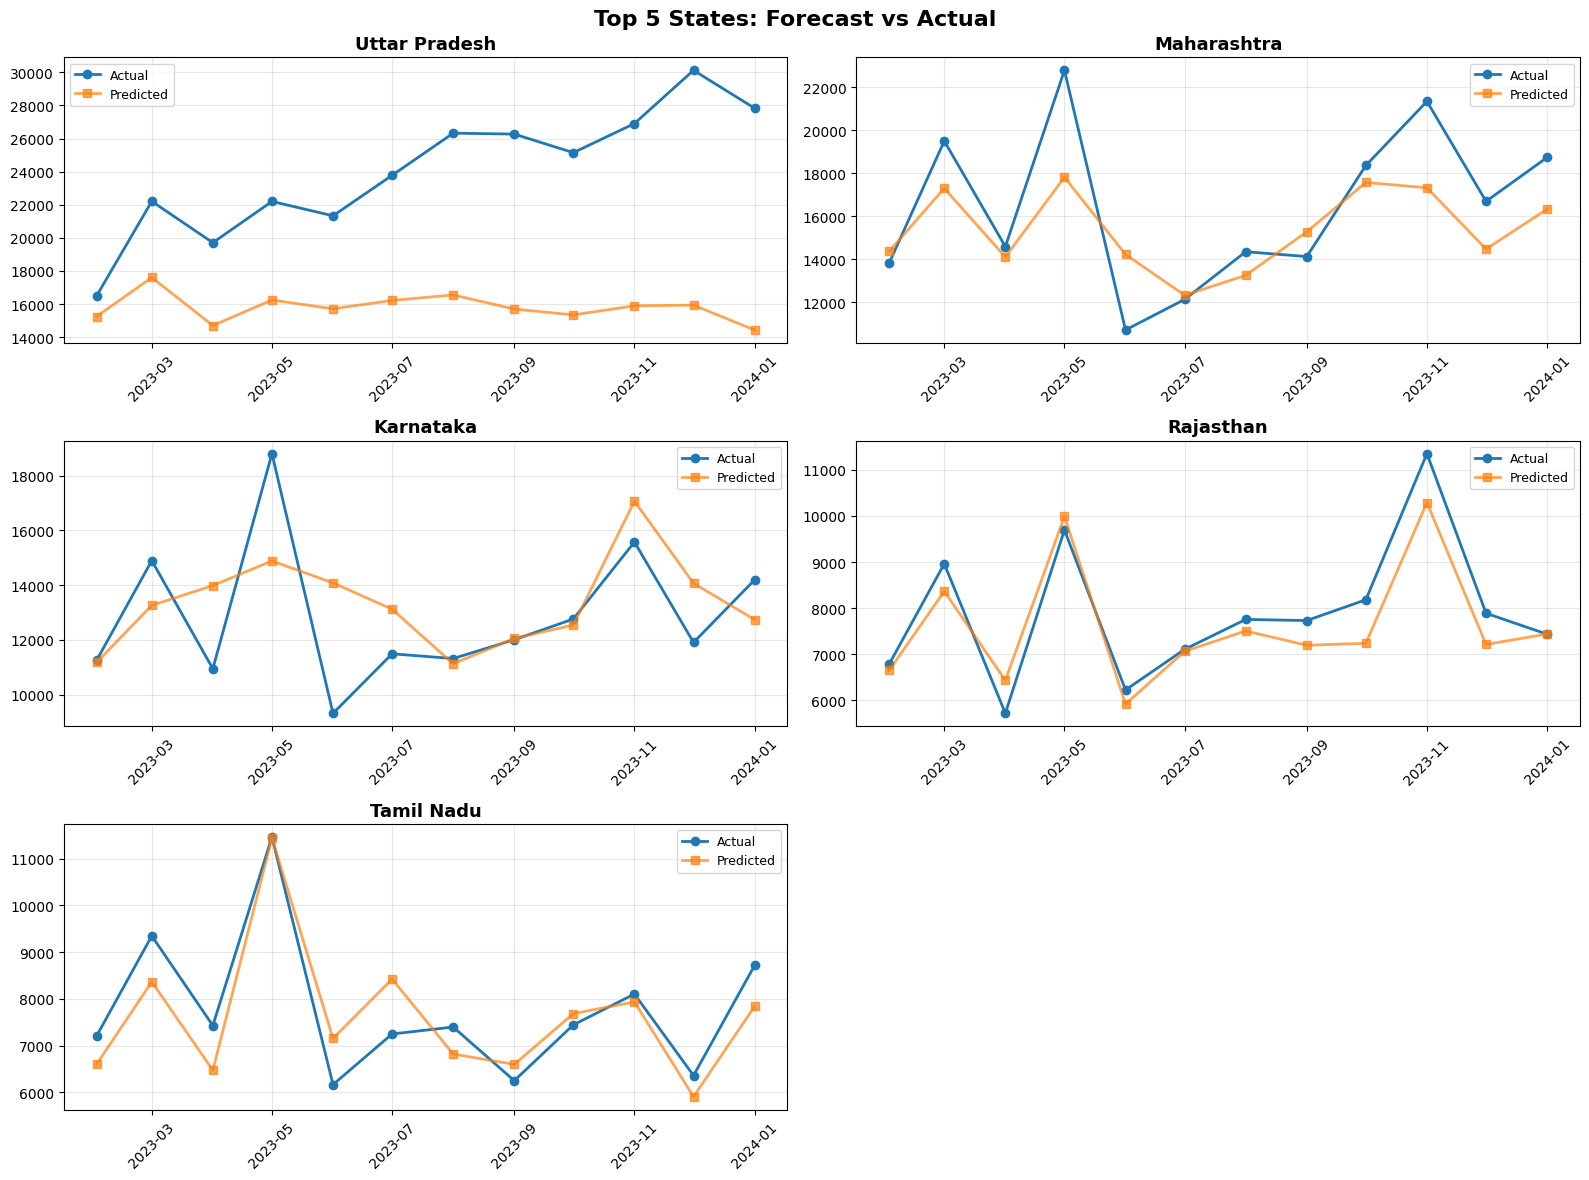

In [66]:
# Top 5 states
top_states = test_original.groupby('State')['EV_Sales_Quantity'].sum().nlargest(5).index

fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, state in enumerate(top_states):
    state_data = test_original[test_original['State'] == state]

    axes[idx].plot(state_data['Date'], state_data['EV_Sales_Quantity'],
                   label='Actual', marker='o', linewidth=2)
    axes[idx].plot(state_data['Date'], state_data['predictions'],
                   label='Predicted', marker='s', linewidth=2, alpha=0.7)

    axes[idx].set_title(f'{state}', fontsize=13, fontweight='bold')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

fig.delaxes(axes[5])
plt.suptitle('Top 5 States: Forecast vs Actual', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 7: Generate Monthly Forecasts

In [67]:
print("GENERATING MONTHLY FORECASTS")

# Get latest data for each state
latest_data = state_monthly.groupby('State').last().reset_index()

# Predict
X_forecast = latest_data[feature_cols]
forecasts = model.predict(X_forecast)

# Create forecast dataframe
forecast_df = pd.DataFrame({
    'State': latest_data['State'],
    'Current_Monthly_Sales': latest_data['EV_Sales_Quantity'],
    'Predicted_Monthly_Sales': forecasts,
    'Absolute_Growth': forecasts - latest_data['EV_Sales_Quantity'].values,
    'Growth_Rate_%': ((forecasts - latest_data['EV_Sales_Quantity'].values) /
                      (latest_data['EV_Sales_Quantity'].values + 1)) * 100
})

forecast_df = forecast_df.sort_values('Absolute_Growth', ascending=False)

print("\n✓ Forecasts generated")
print(f"\nTop 10 States by Growth Potential:")
print("="*70)
print(forecast_df.head(10).to_string(index=False))

# Save results
forecast_df.to_csv('ev_sales_forecast.csv', index=False)
feature_importance.to_csv('feature_importance.csv', index=False)

print("\n✓ Results saved!")
print("  - ev_sales_forecast.csv")
print("  - feature_importance.csv")

GENERATING MONTHLY FORECASTS

✓ Forecasts generated

Top 10 States by Growth Potential:
            State  Current_Monthly_Sales  Predicted_Monthly_Sales  Absolute_Growth  Growth_Rate_%
          Gujarat                 6288.0              7067.077637       779.077637      12.387941
            Bihar                 8375.0              9103.950195       728.950195       8.702844
     Chhattisgarh                 3579.0              4132.017578       553.017578      15.447418
   Andhra Pradesh                 2353.0              2541.911133       188.911133       8.025112
           Punjab                 2465.0              2539.056641        74.056641       3.003108
           Odisha                 4444.0              4505.883789        61.883789       1.392211
              Goa                  928.0               977.980774        49.980774       5.380062
      Uttarakhand                 1234.0              1251.134033        17.134033       1.387371
Jammu And Kashmir             